# Rocket Car

\begin{equation}
\begin{array}{rrclcl}
\displaystyle \min_{u} & {\int_{0}^{T} \frac{1}{2} u(t)^2 dt}\\
\textrm{s.t.} &{\dot s = v}\\
&{\dot v = u} \\
&{s(0) = 0}    \\
&{v(0) = 0}    \\
&{r(T, y(t)) = \begin{bmatrix}
           s(T) -d \\
           v(T) \\
         \end{bmatrix}} &=0   \\
\end{array}
\end{equation}

-----------------

![RocketCar](https://www.researchgate.net/profile/John_Burns6/publication/267218497/figure/fig5/AS:641369194364932@1529925740408/The-Rocket-Car-Control-Problem.png)

In [3]:
# importing required packages.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as env
import pyomo.dae as dae
import plotly.express as px

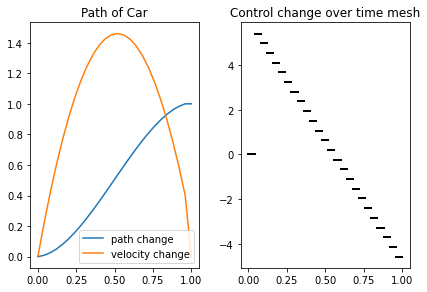

In [11]:
# Initialize general tuning variables
t_f = 1
control = 15
distance = 1

# Initialize model object
Rocket = env.ConcreteModel()

# Initialize time variable
# Rocket.tf = env.Var(domain=env.NonNegativeReals)
Rocket.t = dae.ContinuousSet(bounds=(0, t_f))

# Define control
Rocket.u = env.Var(Rocket.t, bounds=(-control, control))


# Define dependent variables
Rocket.x = env.Var(Rocket.t)
Rocket.v = env.Var(Rocket.t)

# Define derivatives
Rocket.x_dot = dae.DerivativeVar(Rocket.x)
Rocket.v_dot = dae.DerivativeVar(Rocket.v)

# Define ODE constraints
Rocket.ode_x = env.Constraint(Rocket.t, rule=lambda m, t: m.x_dot[t] == m.v[t])
Rocket.ode_v = env.Constraint(Rocket.t, rule=lambda m, t: m.v_dot[t] == m.u[t])

# Set initial and final conditions
Rocket.bounds = env.ConstraintList()
Rocket.bounds.add(Rocket.x[0] == 0)
Rocket.bounds.add(Rocket.v[0] == 0)
# Rocket.bounds.add(Rocket.u[0] == 1)
Rocket.bounds.add(Rocket.x[t_f] == distance)
Rocket.bounds.add(Rocket.v[t_f] == 0)

# Define model objective
Rocket.Integral = dae.Integral(Rocket.t, wrt=Rocket.t, rule=lambda m, t: 0.5*(m.u[t]**2))
Rocket.objective = env.Objective(expr=Rocket.Integral)

# %% Solve system
env.TransformationFactory('dae.finite_difference').apply_to(Rocket, wrt=Rocket.t, nfe=25)
env.SolverFactory('ipopt').solve(Rocket)

# %% Plotting results
time = np.array([t for t in Rocket.t])
x = np.array([Rocket.x[t]() for t in Rocket.t])
v = np.array([Rocket.v[t]() for t in Rocket.t])
u = np.array([Rocket.u[t]() for t in Rocket.t])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()
axes[0].plot(time, x, label="path change")
axes[0].plot(time, v, label="velocity change")
axes[0].set_title("Path of Car")
axes[0].legend()

for i in range(np.size(u)-1):
    u_temp = ([u[i], u[i]])
    x_temp = ([time[i], time[i+1]])
    axes[1].plot(x_temp, u_temp, '-', lw=2, color='k')
axes[1].set_title("Control change over time mesh")
plt.show()
